# Carga de datos

In [1]:
# Instalar dependencias necesarias (solo la primera vez)
!pip install rpy2
!pip install pyreadr # Install the pyreadr package, it is a modern and better alternative to rdata.
!pip install rdata # Install rdata to resolve the ModuleNotFoundError
!pip install xgboost
%pip install tensorflow
!pip install streamlit

import os
import urllib.request
import rdata
import pandas as pd

# Nombre del archivo a usar
file_name = "Madrid_Sale.rda"
file_url = f"https://github.com/paezha/idealista18/raw/master/data/{file_name}"
file_path = os.path.join("data", file_name)

# Crear carpeta 'data' si no existe
os.makedirs("data", exist_ok=True)

# Descargar el archivo si no existe
if not os.path.isfile(file_path):
    print("Descargando archivo...")
    urllib.request.urlretrieve(file_url, file_path)
else:
    print("Archivo ya existe.")

# Leer el archivo .rda
data = rdata.read_rda(file_path)

# Ver claves disponibles en el archivo
print("Claves en el archivo:", data.keys())

# Extraer el DataFrame principal
madrid_sale_df = data['Madrid_Sale']

# Mostrar las primeras filas
print(madrid_sale_df.head())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.7/411.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 124.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.0 MB/s eta 0:00:00
Descargando archivo...


/usr/local/lib/python3.11/dist-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "bbox". The underlying R object is returned instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "crs". The underlying R object is returned instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "XY". The constructor for class "POINT" will be used instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "POINT". The constructor for class "sfg" will be used instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "sfg". The underlying R object is returned instead.
  warnings.warn(
/usr/local/lib/python3.

Claves en el archivo: dict_keys(['Madrid_Sale'])
                 ASSETID  PERIOD     PRICE    UNITPRICE  CONSTRUCTEDAREA  \
1  A15019136831406238029  201803  126000.0  2680.851064               47   
2   A6677225905472065344  201803  235000.0  4351.851852               54   
3  A13341979748618524775  201803  373000.0  4973.333333               75   
4   A4775182175615276542  201803  284000.0  5916.666667               48   
5   A2492087730711701973  201803  228000.0  4560.000000               50   

   ROOMNUMBER  BATHNUMBER  HASTERRACE  HASLIFT  HASAIRCONDITIONING  ...  \
1           1           1           0        1                   1  ...   
2           1           1           0        0                   0  ...   
3           2           1           0        0                   1  ...   
4           1           1           0        1                   1  ...   
5           0           1           0        0                   0  ...   

   CADASTRALQUALITYID  BUILTTYPEID_1  BUILT

# Análisis de datos

En primer lugar, se va a realizar un análisis de todas las columnas

In [3]:
madrid_sale_df.columns

Index(['ASSETID', 'PERIOD', 'PRICE', 'UNITPRICE', 'CONSTRUCTEDAREA',
       'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE', 'HASLIFT',
       'HASAIRCONDITIONING', 'AMENITYID', 'HASPARKINGSPACE',
       'ISPARKINGSPACEINCLUDEDINPRICE', 'PARKINGSPACEPRICE',
       'HASNORTHORIENTATION', 'HASSOUTHORIENTATION', 'HASEASTORIENTATION',
       'HASWESTORIENTATION', 'HASBOXROOM', 'HASWARDROBE', 'HASSWIMMINGPOOL',
       'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
       'CONSTRUCTIONYEAR', 'FLOORCLEAN', 'FLATLOCATIONID',
       'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT',
       'CADASTRALQUALITYID', 'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
       'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO',
       'DISTANCE_TO_CASTELLANA', 'LONGITUDE', 'LATITUDE', 'geometry'],
      dtype='object')

In [4]:
madrid_sale_df = madrid_sale_df.drop(columns=['ASSETID',"geometry"])

Ahora se va a realizar un análisis de correlación contra la variable Price, para posteriormente ver como son esas variables

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr, f_oneway

# Copiar el DataFrame original
df = madrid_sale_df.copy()

# Inicializar diccionarios para resultados
correlaciones_pearson = {}
correlaciones_spearman = {}
anova_categoricas = {}

# Columnas a excluir manualmente
excluded_cols = ['UNITPRICE']

# Iterar sobre todas las columnas
for col in df.columns:
    if col == 'PRICE' or col in excluded_cols:
        continue

    n_unique = df[col].nunique(dropna=True)

    # Variables continuas: numéricas con más de 10 valores únicos
    if n_unique > 10:
        try:
            valid_rows = df[['PRICE', col]].dropna()
            pearson_corr, _ = pearsonr(valid_rows['PRICE'], valid_rows[col])
            spearman_corr, _ = spearmanr(valid_rows['PRICE'], valid_rows[col])
            correlaciones_pearson[col] = pearson_corr
            correlaciones_spearman[col] = spearman_corr
        except Exception as e:
            print(f"No se pudo calcular correlación para {col}: {e}")

    # Variables categóricas: pocas categorías (<= 10)
    elif n_unique <= 10:
        try:
            groups = [group['PRICE'].dropna() for name, group in df[[col, 'PRICE']].groupby(col)]
            if len(groups) > 1:
                _, p_val = f_oneway(*groups)
                anova_categoricas[col] = p_val
        except Exception as e:
            print(f"No se pudo calcular ANOVA para {col}: {e}")

# Crear DataFrames con resultados ordenados
df_pearson = pd.DataFrame.from_dict(correlaciones_pearson, orient='index', columns=['Pearson con PRICE'])
df_pearson = df_pearson.sort_values(by='Pearson con PRICE', ascending=False)

df_spearman = pd.DataFrame.from_dict(correlaciones_spearman, orient='index', columns=['Spearman con PRICE'])
df_spearman = df_spearman.sort_values(by='Spearman con PRICE', ascending=False)

df_anova = pd.DataFrame.from_dict(anova_categoricas, orient='index', columns=['p-valor ANOVA'])
df_anova = df_anova.sort_values(by='p-valor ANOVA')

# Mostrar resultados
print("\n--- Correlaciones Pearson (continuas) ---")
print(df_pearson)

print("\n--- Correlaciones Spearman (continuas) ---")
print(df_spearman)

print("\n--- p-valores ANOVA (categóricas) ---")
print(df_anova)



--- Correlaciones Pearson (continuas) ---
                         Pearson con PRICE
CONSTRUCTEDAREA                   0.859471
BATHNUMBER                        0.717569
ROOMNUMBER                        0.464571
LATITUDE                          0.246950
FLOORCLEAN                        0.176653
CADMAXBUILDINGFLOOR               0.165207
PARKINGSPACEPRICE                 0.054933
CADDWELLINGCOUNT                 -0.000711
DISTANCE_TO_METRO                -0.011383
LONGITUDE                        -0.035541
CONSTRUCTIONYEAR                 -0.056794
CADCONSTRUCTIONYEAR              -0.074108
DISTANCE_TO_CITY_CENTER          -0.201389
DISTANCE_TO_CASTELLANA           -0.249092

--- Correlaciones Spearman (continuas) ---
                         Spearman con PRICE
CONSTRUCTEDAREA                    0.725092
BATHNUMBER                         0.671420
LATITUDE                           0.456912
ROOMNUMBER                         0.395370
CADMAXBUILDINGFLOOR                0.361696
FLOO

Una vez análizado cuales son las variables mas correlacionadas con la variable objetivo, que son CONSTRUCTEDAREA, BATHNUMER, ROOMNUMBER, HASAIRCONDITIONING y HASLIFT, se van a representar graficamente. Previamente, se va a representar la variable PRICE

Variable PRICE

In [ ]:
df['PRICE'].describe()

,PRICE
count,9.481500e+04
mean,3.961101e+05
std,4.170744e+05
min,2.100000e+04
25%,1.600000e+05
50%,2.620000e+05
75%,4.670000e+05
max,8.133000e+06


In [ ]:
# Encontrar el registro con el valor máximo de PRICE
max_price = 8.133000e+06
max_price_row = df[df['PRICE'] == max_price]

# Verificar si se encontró el registro
if not max_price_row.empty:
    print("Registro con el valor máximo de PRICE (8,133,000):")
    print(max_price_row)
else:
    print(f"No se encontró un registro con PRICE igual a {max_price}. Verifica el valor o el DataFrame.")

Registro con el valor máximo de PRICE (8,133,000):
       PERIOD      PRICE    UNITPRICE  CONSTRUCTEDAREA  ROOMNUMBER  \
56067  201812  8133000.0  8707.708779              934           8   

       BATHNUMBER  HASTERRACE  HASLIFT  HASAIRCONDITIONING  AMENITYID  ...  \
56067          10           0        0                   0          3  ...   

       CADDWELLINGCOUNT  CADASTRALQUALITYID  BUILTTYPEID_1  BUILTTYPEID_2  \
56067                 2                   2              0              0   

       BUILTTYPEID_3  DISTANCE_TO_CITY_CENTER  DISTANCE_TO_METRO  \
56067              1                 3.252209           0.507632   

       DISTANCE_TO_CASTELLANA  LONGITUDE  LATITUDE  
56067                0.123339  -3.690056  40.44387  

[1 rows x 40 columns]


Variable constructed area

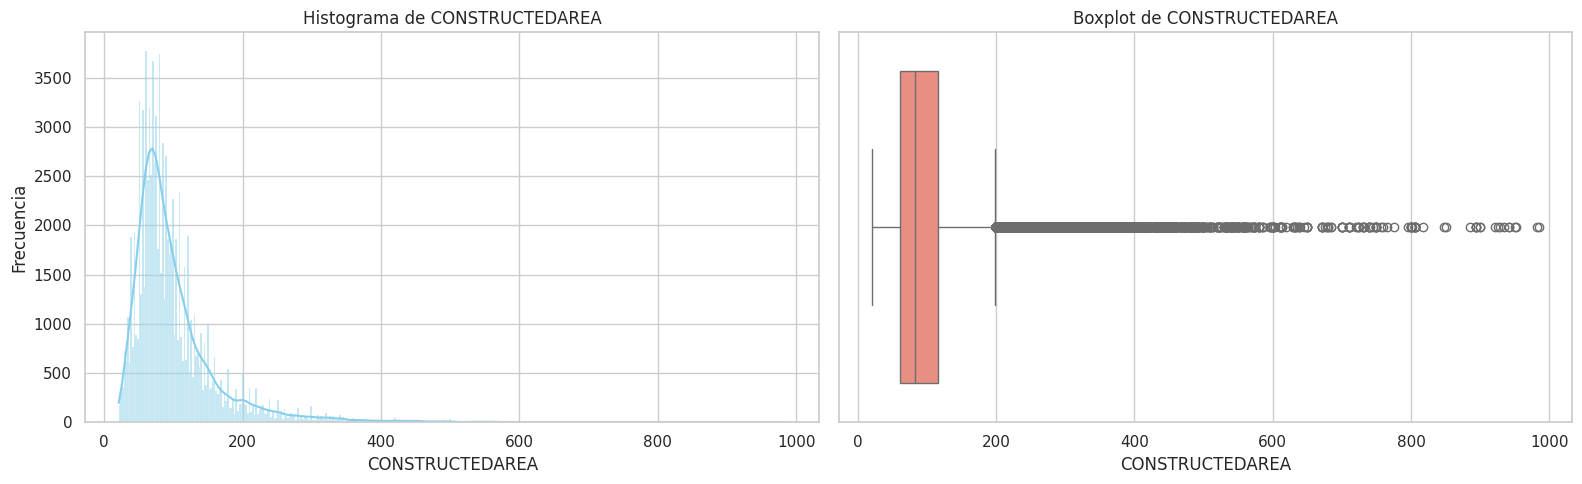

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Configuración general de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ANÁLISIS DE LA VARIABLE PRICE
col = 'CONSTRUCTEDAREA'

# Crear figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histograma
sns.histplot(df[col].dropna(), kde=True, ax=axes[0], color="skyblue")
axes[0].set_title(f"Histograma de {col}")
axes[0].set_xlabel(col)
axes[0].set_ylabel("Frecuencia")

# Boxplot
sns.boxplot(x=df[col].dropna(), ax=axes[1], color="salmon")
axes[1].set_title(f"Boxplot de {col}")
axes[1].set_xlabel(col)

plt.tight_layout()
plt.show()

Variable BATNUMBER

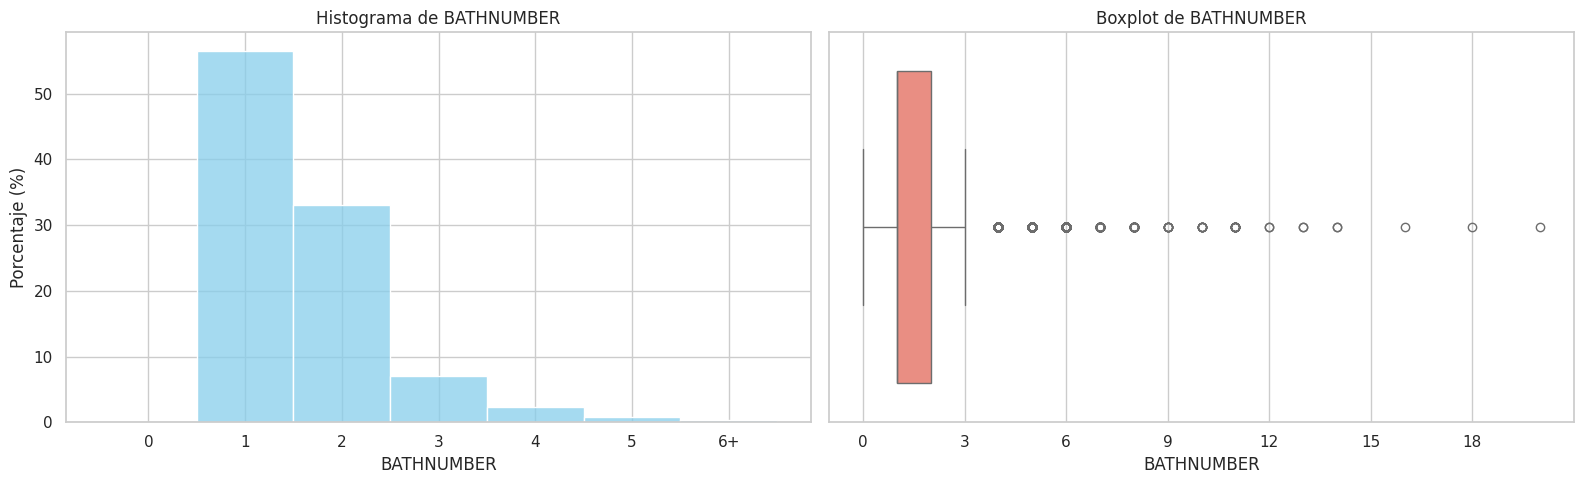

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Asegúrate de tener cargado tu DataFrame como `df`

# Configuración general de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ANÁLISIS DE LA VARIABLE BATHNUMBER
col = 'BATHNUMBER'

# Crear una copia de la columna y agrupar valores > 6
df_temp = df[[col]].copy()
df_temp['BATHNUMBER_CATEG'] = df_temp[col].apply(lambda x: str(x) if x <= 5 else '6+' if pd.notnull(x) else x)

# Definir el orden explícito de las categorías como tipo categórico
category_order = ['0', '1', '2', '3', '4', '5', '6+']
df_temp['BATHNUMBER_CATEG'] = pd.Categorical(df_temp['BATHNUMBER_CATEG'], categories=category_order, ordered=True)

# Crear figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histograma con porcentajes y orden explícito
sns.histplot(data=df_temp, x='BATHNUMBER_CATEG', ax=axes[0], color="skyblue", stat="percent")
axes[0].set_title(f"Histograma de {col}")
axes[0].set_xlabel(col)
axes[0].set_ylabel("Porcentaje (%)")

# Boxplot de la variable original con ticks de 3 en 3
sns.boxplot(x=df[col].dropna(), ax=axes[1], color="salmon")
axes[1].set_title(f"Boxplot de {col}")
axes[1].set_xlabel(col)
# Ajustar los ticks del eje x a valores enteros de 3 en 3
min_val = int(df[col].dropna().min())
max_val = int(df[col].dropna().max())
integer_ticks = range(min_val - (min_val % 3), max_val + 1, 3)
axes[1].set_xticks(integer_ticks)

plt.tight_layout()
plt.show()

In [6]:
# Encontrar el registro con el valor máximo de bathnumber
max_bath = 20
max_bath_row = df[df['BATHNUMBER'] == max_bath]

# Verificar si se encontró el registro
if not max_bath_row.empty:
    print("Registro con el valor máximo de BATHNUMBER (20):")
    print(max_bath_row)
else:
    print(f"No se encontró un registro con BATHNUMBER igual a {max_bath_row}. Verifica el valor o el DataFrame.")

Registro con el valor máximo de BATHNUMBER (20):
       PERIOD     PRICE    UNITPRICE  CONSTRUCTEDAREA  ROOMNUMBER  BATHNUMBER  \
68892  201806  850000.0  1416.666667              600          20          20   

       HASTERRACE  HASLIFT  HASAIRCONDITIONING  AMENITYID  ...  \
68892           0        0                   1          3  ...   

       CADDWELLINGCOUNT  CADASTRALQUALITYID  BUILTTYPEID_1  BUILTTYPEID_2  \
68892                43                   3              0              1   

       BUILTTYPEID_3  DISTANCE_TO_CITY_CENTER  DISTANCE_TO_METRO  \
68892              0                 2.386553           0.319877   

       DISTANCE_TO_CASTELLANA  LONGITUDE   LATITUDE  
68892                1.130627  -3.678763  40.406766  

[1 rows x 40 columns]


Variable ROOMNUMBER

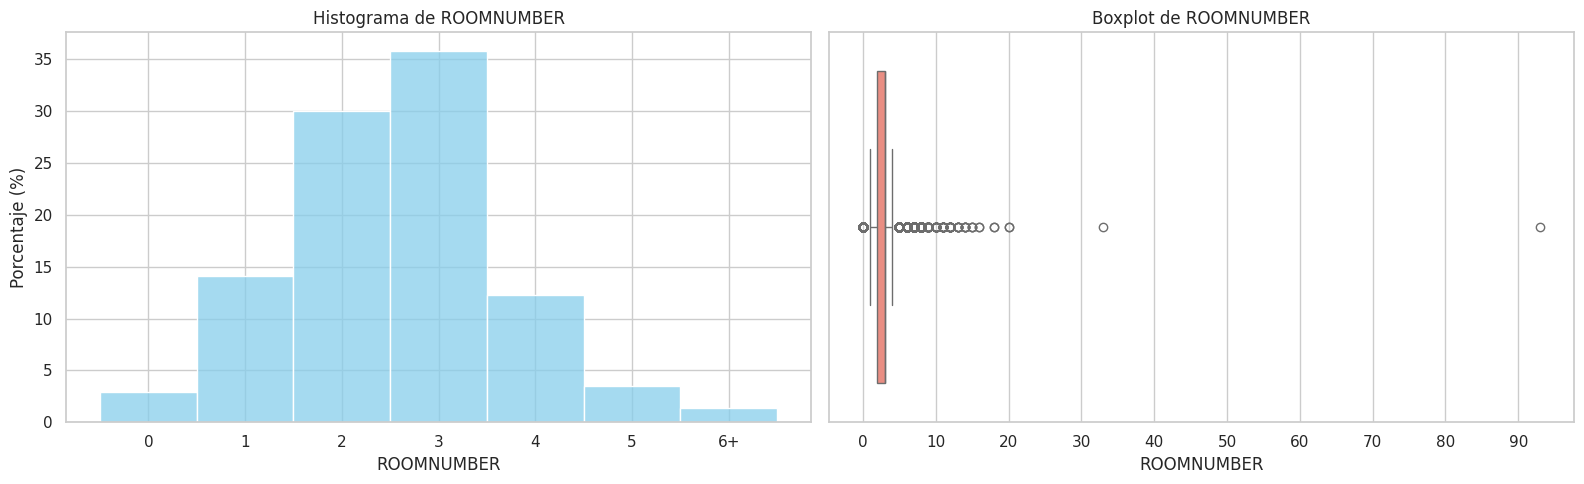

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración general de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ANÁLISIS DE LA VARIABLE ROOMNUMBER
col = 'ROOMNUMBER'

# Crear una copia de la columna y agrupar valores > 6
df_temp = df[[col]].copy()
df_temp['ROOMNUMBER_CATEG'] = df_temp[col].apply(lambda x: str(x) if x <= 5 else '6+' if pd.notnull(x) else x)

# Definir el orden explícito de las categorías como tipo categórico
category_order = ['0', '1', '2', '3', '4', '5', '6+']
df_temp['ROOMNUMBER_CATEG'] = pd.Categorical(df_temp['ROOMNUMBER_CATEG'], categories=category_order, ordered=True)

# Crear figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histograma con porcentajes y orden explícito
sns.histplot(data=df_temp, x='ROOMNUMBER_CATEG', ax=axes[0], color="skyblue", stat="percent")
axes[0].set_title(f"Histograma de {col}")
axes[0].set_xlabel(col)
axes[0].set_ylabel("Porcentaje (%)")

# Boxplot de la variable original con ticks de 3 en 3
sns.boxplot(x=df[col].dropna(), ax=axes[1], color="salmon")
axes[1].set_title(f"Boxplot de {col}")
axes[1].set_xlabel(col)
# Ajustar los ticks del eje x a valores enteros de 3 en 3
min_val = int(df[col].dropna().min())
max_val = int(df[col].dropna().max())
integer_ticks = range(min_val - (min_val % 3), max_val + 1, 10)
axes[1].set_xticks(integer_ticks)

plt.tight_layout()
plt.show()

In [ ]:
# Encontrar el registro con ROOMNUMBER == 93
max_room_number = 93
max_room_number_row = df[df['ROOMNUMBER'] == max_room_number]

# Verificar si se encontró el registro
if not max_room_number_row.empty:
    print("Registro con ROOMNUMBER == 93:")
    print(max_room_number_row)
else:
    print(f"No se encontró un registro con ROOMNUMBER igual a {max_room_number}. Verifica el valor o el DataFrame.")

Registro con ROOMNUMBER == 93:
       PERIOD     PRICE    UNITPRICE  CONSTRUCTEDAREA  ROOMNUMBER  BATHNUMBER  \
17639  201803  450000.0  3781.512605              119          93           2   

       HASTERRACE  HASLIFT  HASAIRCONDITIONING  AMENITYID  ...  \
17639           1        1                   1          3  ...   

       CADDWELLINGCOUNT  CADASTRALQUALITYID  BUILTTYPEID_1  BUILTTYPEID_2  \
17639               421                   4              0              0   

       BUILTTYPEID_3  DISTANCE_TO_CITY_CENTER  DISTANCE_TO_METRO  \
17639              1                 7.020016           0.197061   

       DISTANCE_TO_CASTELLANA  LONGITUDE  LATITUDE  
17639                 5.85295  -3.623555  40.40096  

[1 rows x 40 columns]


In [ ]:
# Encontrar el registro con ROOMNUMBER == 93
max_room_number = 93
max_room_number_row = df[df['ROOMNUMBER'] == max_room_number]

# Verificar si se encontró el registro
if not max_room_number_row.empty:

    # Eliminar el registro con ROOMNUMBER == 93
    df = df[df['ROOMNUMBER'] != max_room_number].reset_index(drop=True)
    print(f"\nRegistro(s) con ROOMNUMBER == {max_room_number} eliminado(s).")
    print("Nuevo tamaño de df:", df.shape)
else:
    print(f"No se encontró un registro con ROOMNUMBER igual a {max_room_number}. Verifica el valor o el DataFrame.")


Registro(s) con ROOMNUMBER == 93 eliminado(s).
Nuevo tamaño de df: (94814, 40)


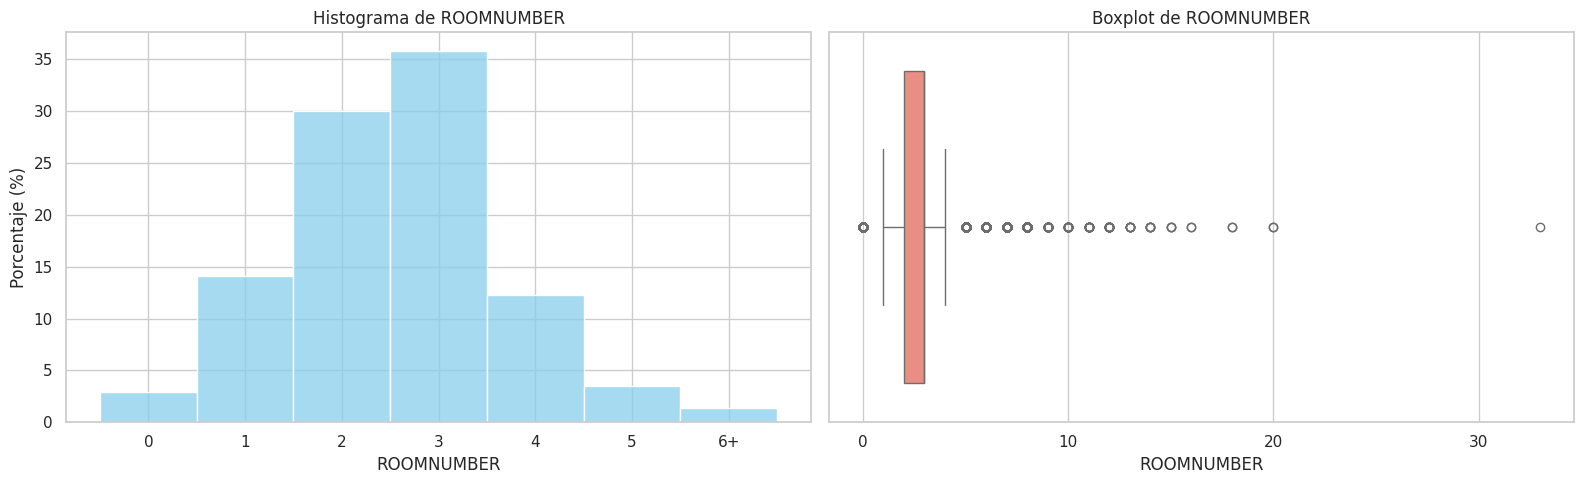

In [ ]:

# Configuración general de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ANÁLISIS DE LA VARIABLE ROOMNUMBER
col = 'ROOMNUMBER'

# Crear una copia de la columna y agrupar valores > 6
df_temp = df[[col]].copy()
df_temp['ROOMNUMBER_CATEG'] = df_temp[col].apply(lambda x: str(x) if x <= 5 else '6+' if pd.notnull(x) else x)

# Definir el orden explícito de las categorías como tipo categórico
category_order = ['0', '1', '2', '3', '4', '5', '6+']
df_temp['ROOMNUMBER_CATEG'] = pd.Categorical(df_temp['ROOMNUMBER_CATEG'], categories=category_order, ordered=True)

# Crear figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histograma con porcentajes y orden explícito
sns.histplot(data=df_temp, x='ROOMNUMBER_CATEG', ax=axes[0], color="skyblue", stat="percent")
axes[0].set_title(f"Histograma de {col}")
axes[0].set_xlabel(col)
axes[0].set_ylabel("Porcentaje (%)")

# Boxplot de la variable original con ticks de 3 en 3
sns.boxplot(x=df[col].dropna(), ax=axes[1], color="salmon")
axes[1].set_title(f"Boxplot de {col}")
axes[1].set_xlabel(col)
# Ajustar los ticks del eje x a valores enteros de 3 en 3
min_val = int(df[col].dropna().min())
max_val = int(df[col].dropna().max())
integer_ticks = range(min_val - (min_val % 3), max_val + 1, 10)
axes[1].set_xticks(integer_ticks)

plt.tight_layout()
plt.show()

Variable HASAIRCONDITIONING y HASLIFT

/tmp/ipython-input-16-625279172.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="pastel")


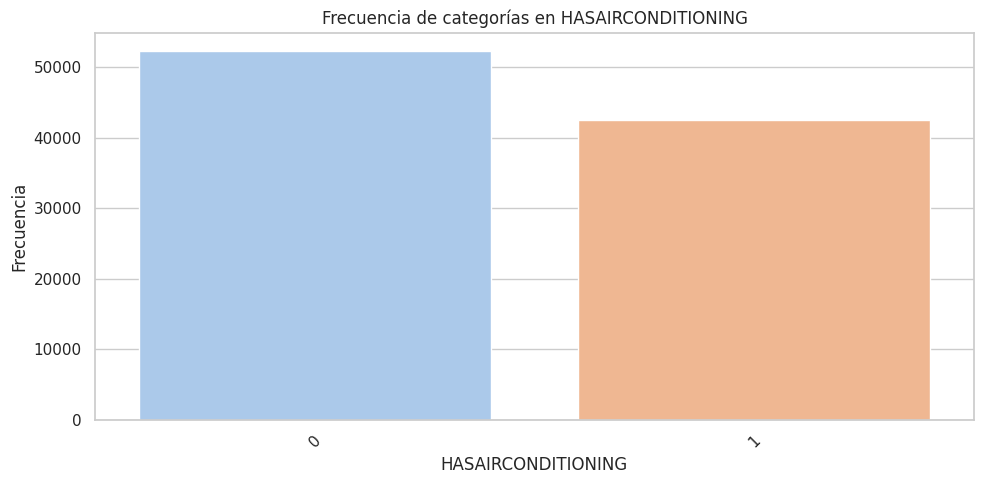

/tmp/ipython-input-16-625279172.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="pastel")


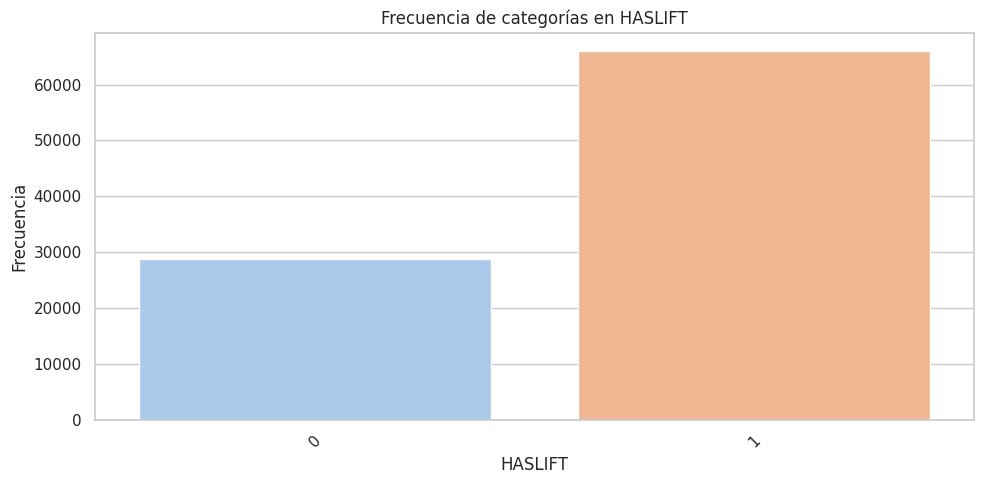

In [ ]:
vars_categoricas = ['HASAIRCONDITIONING', 'HASLIFT']

# Configuración general de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ANÁLISIS DE VARIABLES CATEGÓRICAS
for col in vars_categoricas:
    plt.figure(figsize=(10, 5))

    # Si hay muchas categorías, solo mostramos las más frecuentes
    if df[col].nunique() > 15:
        top_cats = df[col].value_counts().nlargest(15)
        sns.barplot(x=top_cats.index.astype(str), y=top_cats.values, palette="viridis")
        plt.title(f"Top 15 categorías más frecuentes de {col}")
    else:
        sns.countplot(x=col, data=df, palette="pastel")
        plt.title(f"Frecuencia de categorías en {col}")

    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

# Pre-procesamiento de los datos

En primer lugar, se comprueba si existen columnas con datos faltantes

In [ ]:
df.isna().sum()

,0
PERIOD,0
PRICE,0
UNITPRICE,0
CONSTRUCTEDAREA,0
ROOMNUMBER,0
BATHNUMBER,0
HASTERRACE,0
HASLIFT,0
HASAIRCONDITIONING,0
AMENITYID,0


La columna "CONTRUCTIONYEAR" tiene 55.872 missing de 94.814 (58,93%), por lo que se va a eliminar la columna. Sobre el resto de datos faltantes, se va a imputar a través de la mediana.

Posteriormente, se van a eliminar las variables "assetid" por ser únicamente un identificador, "unitprice", porque es el PRICE dividido por los m2, por lo que no tiene sentido mantenerla como variable explicativa, "period", porque todos los pisos son de la misma fecha y "geometry", porque son los datos de longitud y latitud combinados.

In [ ]:
madrid_sale_df_2 = df.drop(columns=["CONSTRUCTIONYEAR", "UNITPRICE", "PERIOD"])

Ahora imputamos los missing a través de los k vecinos

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
madrid_sale_df_2_imputed = pd.DataFrame(
    imputer.fit_transform(madrid_sale_df_2),
    columns=madrid_sale_df_2.columns,
    index=madrid_sale_df_2.index
)



In [ ]:
#Se comprueba si hay missing
madrid_sale_df_2_imputed.isna().sum()

,0
PRICE,0
CONSTRUCTEDAREA,0
ROOMNUMBER,0
BATHNUMBER,0
HASTERRACE,0
HASLIFT,0
HASAIRCONDITIONING,0
AMENITYID,0
HASPARKINGSPACE,0
ISPARKINGSPACEINCLUDEDINPRICE,0


Una vez analizados los missing de cada variable, se va a analizar si existen valores outlier en cada variable. Se va a considerar outlier todo aquel que esté fuera de $[Q1 - 1.5*IQR, Q3 + 1.5*IQR]$

In [ ]:
#Identificar outliers usando IQR
def detect_outliers_iqr(df, columns):
    outliers_dict = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outliers_dict[col] = len(outliers)
    return outliers_dict

continuous_cols = [
    col for col in madrid_sale_df_2_imputed.select_dtypes(include=['number']).columns
    if madrid_sale_df_2_imputed[col].nunique(dropna=True) > 10 and col != 'CADASTRALQUALITYID'
]

outliers_summary = detect_outliers_iqr(madrid_sale_df_2_imputed, continuous_cols)

print("Número de outliers por columna:")
for col, count in outliers_summary.items():
    print(f"{col}: {count} outliers")

Número de outliers por columna:
PRICE: 6782 outliers
CONSTRUCTEDAREA: 6957 outliers
ROOMNUMBER: 7419 outliers
BATHNUMBER: 3118 outliers
PARKINGSPACEPRICE: 2191 outliers
FLOORCLEAN: 2317 outliers
CADCONSTRUCTIONYEAR: 6381 outliers
CADMAXBUILDINGFLOOR: 4055 outliers
CADDWELLINGCOUNT: 10854 outliers
DISTANCE_TO_CITY_CENTER: 800 outliers
DISTANCE_TO_METRO: 6923 outliers
DISTANCE_TO_CASTELLANA: 2809 outliers
LONGITUDE: 4201 outliers
LATITUDE: 182 outliers


Ahora se divide en train/test y cada uno de ellos en variable objetivo, que es "PRICE" y variables explicativas, el resto.

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir en 80% train y 20% test (puedes ajustar test_size según necesites)
madrid_sale_train_df, madrid_sale_test_df = train_test_split(
    madrid_sale_df_2_imputed,
    test_size=0.2,
    random_state=42
)
#Train
madrid_sale_train_df_obj=madrid_sale_train_df["PRICE"]
madrid_sale_train_df_expl = madrid_sale_train_df.drop(columns=["PRICE"])
#Test
madrid_sale_test_df_obj=madrid_sale_test_df["PRICE"]
madrid_sale_test_df_expl = madrid_sale_test_df.drop(columns=["PRICE"])

## PCA al conjunto de entrenamiento

En este punto, se va a aplicar PCA, que es una técnica que transforma un conjunto de variables posiblemente correlacionadas en un conjunto de variables no correlacionadas llamadas componentes principales. Estos componentes capturan la mayor parte de la variabilidad de los datos con menos dimensiones.

### PCA Lineal

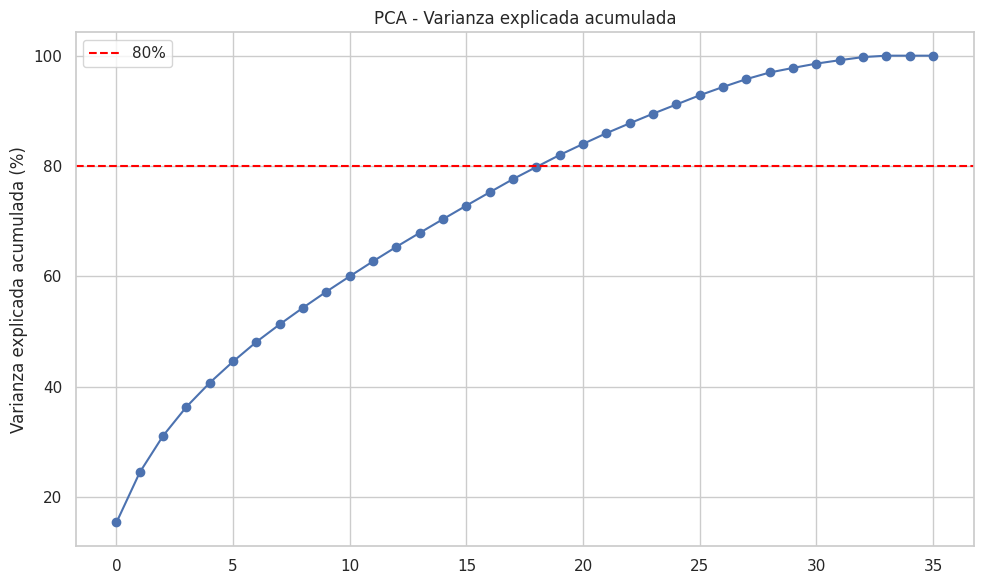

Componentes necesarias para explicar el 80% de la varianza: 20


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

#Selección del DataFrame ya preprocesado
df = madrid_sale_train_df_expl.copy()

#Estandarización de los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

#PCA clásico
pca = PCA()
pca.fit(df_scaled)

#Varianza explicada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Gráfico de varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance * 100, marker='o')
plt.ylabel('Varianza explicada acumulada (%)')
plt.title('PCA - Varianza explicada acumulada')
plt.grid(True)
plt.axhline(80, color='red', linestyle='--', label='80%')
plt.legend()
plt.tight_layout()
plt.show()

# Cuántas componentes necesitamos para el 80%
n_components_90 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"Componentes necesarias para explicar el 80% de la varianza: {n_components_90}")

### PCA con kernel

#### Núcleo Sigmoide

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Liberar memoria
gc.collect()

# Paso 1: Cargar y preparar los datos
df = madrid_sale_train_df_expl.copy().astype(np.float32)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Paso 2: KernelPCA
n_components = 40
kpca = KernelPCA(
    n_components=n_components,
    kernel='sigmoid',
    eigen_solver='randomized',
    n_jobs=-1,
    fit_inverse_transform=False
)
X_kpca = kpca.fit_transform(df_scaled)

# Paso 3: Calcular varianza explicada (estimada)
component_variances = np.var(X_kpca, axis=0)
explained_variance_ratio_kpca = component_variances / np.sum(component_variances)
cumulative_variance_kpca = np.cumsum(explained_variance_ratio_kpca)

# Paso 4: Tabla de varianza explicada
df_varianza = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(n_components)],
    'Varianza Explicada (%)': explained_variance_ratio_kpca * 100,
    'Varianza Acumulada (%)': cumulative_variance_kpca * 100
})

print("\nVarianza explicada por cada componente principal:")
print(df_varianza.round(2))

# Paso 5: Gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, n_components + 1), y=cumulative_variance_kpca * 100, marker='o')
plt.axhline(80, color='red', linestyle='--', label='80%')
plt.axhline(90, color='green', linestyle='--', label='90%')
plt.xticks(range(1, n_components + 1))
plt.xlabel('Número de componentes principales (Kernel PCA)')
plt.ylabel('Varianza explicada acumulada (%)')
plt.title('Kernel PCA (sigmoid) - Varianza explicada')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 6: Componentes necesarias para explicar el 80%
n_components_80 = np.argmax(cumulative_variance_kpca >= 0.80) + 1
print(f"\nComponentes necesarias para explicar el 80% de la varianza (estimado): {n_components_80}")


KeyboardInterrupt: 

#### Núcleo rbf


Varianza explicada por cada componente principal (Kernel RBF):
   Componente  Varianza Explicada (%)  Varianza Acumulada (%)
0         PC1                   15.78               15.780000
1         PC2                    7.71               23.480000
2         PC3                    7.43               30.920000
3         PC4                    5.96               36.869999
4         PC5                    4.42               41.290001
5         PC6                    3.88               45.169998
6         PC7                    3.50               48.660000
7         PC8                    3.32               51.990002
8         PC9                    2.92               54.900002
9        PC10                    2.88               57.790001
10       PC11                    2.73               60.520000
11       PC12                    2.61               63.119999
12       PC13                    2.58               65.699997
13       PC14                    2.40               68.099998
14    

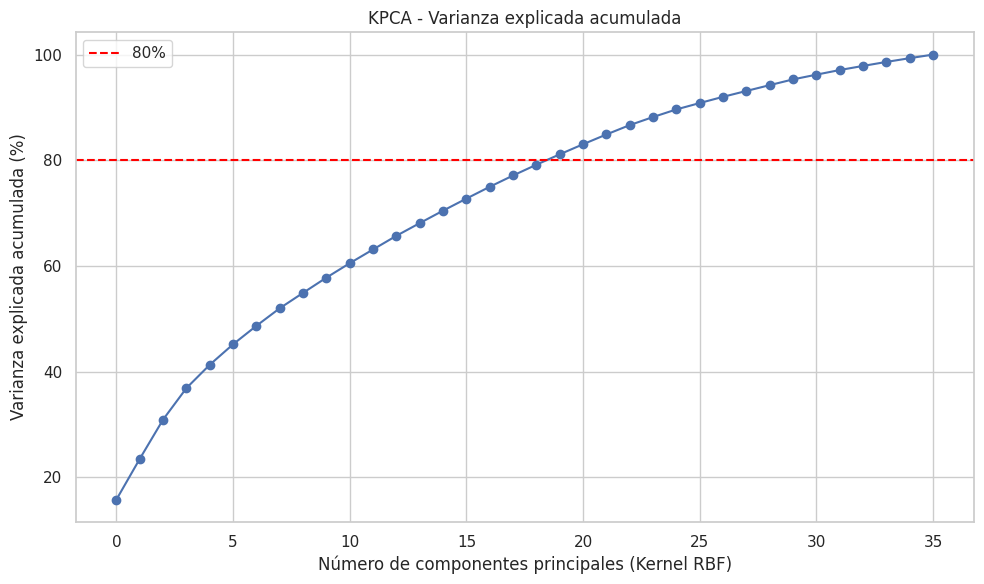


Componentes necesarias para explicar el 80% de la varianza (estimado): 20


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Liberar memoria
gc.collect()

# Paso 1: Cargar y preparar los datos
df = madrid_sale_train_df_expl.copy().astype(np.float32)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Paso 2: KernelPCA
n_components = 36
kpca = KernelPCA(
    n_components=n_components,
    kernel='rbf',  # Cambiado de 'sigmoid' a 'rbf'
    eigen_solver='randomized',
    n_jobs=-1,
    fit_inverse_transform=False
)
X_kpca = kpca.fit_transform(df_scaled)

# Paso 3: Calcular varianza explicada (estimada)
component_variances = np.var(X_kpca, axis=0)
explained_variance_ratio_kpca = component_variances / np.sum(component_variances)
cumulative_variance_kpca = np.cumsum(explained_variance_ratio_kpca)

# Paso 4: Tabla de varianza explicada
df_varianza = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(n_components)],
    'Varianza Explicada (%)': explained_variance_ratio_kpca * 100,
    'Varianza Acumulada (%)': cumulative_variance_kpca * 100
})

print("\nVarianza explicada por cada componente principal (Kernel RBF):")
print(df_varianza.round(2))


# Gráfico de varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_kpca * 100, marker='o')
plt.ylabel('Varianza explicada acumulada (%)')
plt.xlabel('Número de componentes principales (Kernel RBF)')
plt.title('KPCA - Varianza explicada acumulada')
plt.grid(True)
plt.axhline(80, color='red', linestyle='--', label='80%')
plt.legend()
plt.tight_layout()
plt.show()

# Paso 6: Componentes necesarias para explicar el 80%
n_components_80 = np.argmax(cumulative_variance_kpca >= 0.80) + 1
print(f"\nComponentes necesarias para explicar el 80% de la varianza (estimado): {n_components_80}")


#### Polinómico


Varianza explicada por cada componente principal (Kernel PCA - estimado):
   Componente  Varianza Explicada (%)  Varianza Acumulada (%)
0         PC1               99.739998               99.739998
1         PC2                0.250000              100.000000
2         PC3                0.000000              100.000000
3         PC4                0.000000              100.000000
4         PC5                0.000000              100.000000
5         PC6                0.000000              100.000000
6         PC7                0.000000              100.000000
7         PC8                0.000000              100.000000
8         PC9                0.000000              100.000000
9        PC10                0.000000              100.000000
10       PC11                0.000000              100.000000
11       PC12                0.000000              100.000000
12       PC13                0.000000              100.000000
13       PC14                0.000000              100.00

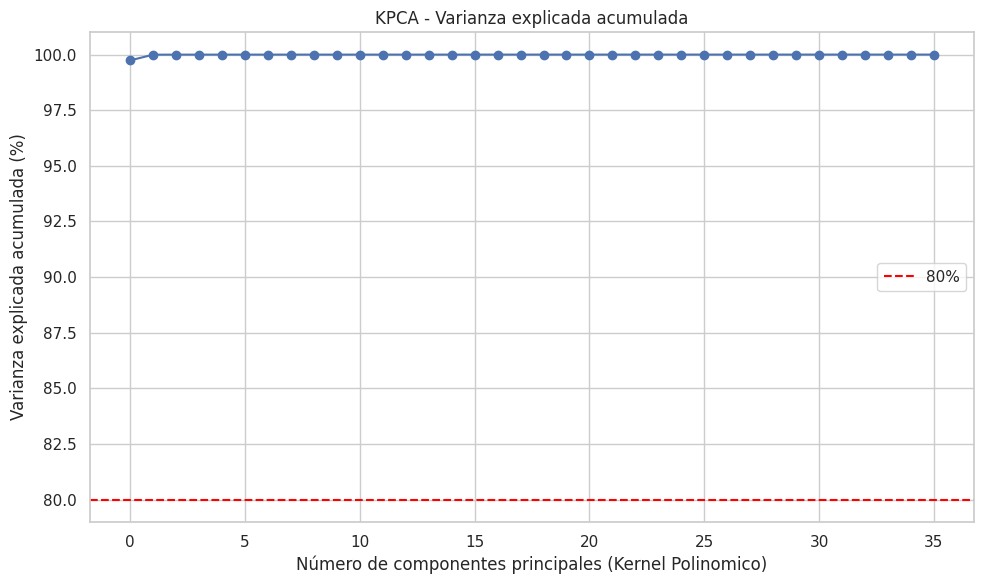


Componentes necesarias para explicar el 80% de la varianza (estimado): 1


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Liberar memoria
gc.collect()

#Cargar y preparar los datos
df = madrid_sale_train_df_expl.copy().astype(np.float32)  # Reducir precisión
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

#KernelPCA con kernel polinómico
n_components = 36
kpca = KernelPCA(
    n_components=n_components,
    kernel='poly',
    degree=3,
    coef0=0.5,
    gamma=0.01,
    eigen_solver='randomized',
    n_jobs=-1,
    fit_inverse_transform=False
)


X_kpca = kpca.fit_transform(df_scaled)

#Calcular varianza explicada (estimada)
component_variances = np.var(X_kpca, axis=0)
explained_variance_ratio_kpca = component_variances / np.sum(component_variances)
cumulative_variance_kpca = np.cumsum(explained_variance_ratio_kpca)

#Tabla de varianza explicada
df_varianza = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(n_components)],
    'Varianza Explicada (%)': explained_variance_ratio_kpca * 100,
    'Varianza Acumulada (%)': cumulative_variance_kpca * 100
})

print("\nVarianza explicada por cada componente principal (Kernel PCA - estimado):")
print(df_varianza.round(2))

#Gráfico
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_kpca * 100, marker='o')
plt.ylabel('Varianza explicada acumulada (%)')
plt.xlabel('Número de componentes principales (Kernel Polinomico)')
plt.title('KPCA - Varianza explicada acumulada')
plt.grid(True)
plt.axhline(80, color='red', linestyle='--', label='80%')
plt.legend()
plt.tight_layout()
plt.show()

#Componentes necesarias para explicar el 80%
n_components_80 = np.argmax(cumulative_variance_kpca >= 0.80) + 1
print(f"\nComponentes necesarias para explicar el 80% de la varianza (estimado): {n_components_80}")


#### Cosine


Varianza explicada por cada componente principal (Kernel PCA - estimado):
   Componente  Varianza Explicada (%)  Varianza Acumulada (%)
0         PC1                   15.51               15.510000
1         PC2                    8.64               24.150000
2         PC3                    7.52               31.670000
3         PC4                    5.42               37.090000
4         PC5                    4.69               41.770000
5         PC6                    4.35               46.119999
6         PC7                    3.74               49.849998
7         PC8                    3.33               53.180000
8         PC9                    3.20               56.380001
9        PC10                    3.04               59.419998
10       PC11                    3.00               62.430000
11       PC12                    2.93               65.349998
12       PC13                    2.68               68.040001
13       PC14                    2.64               70.66

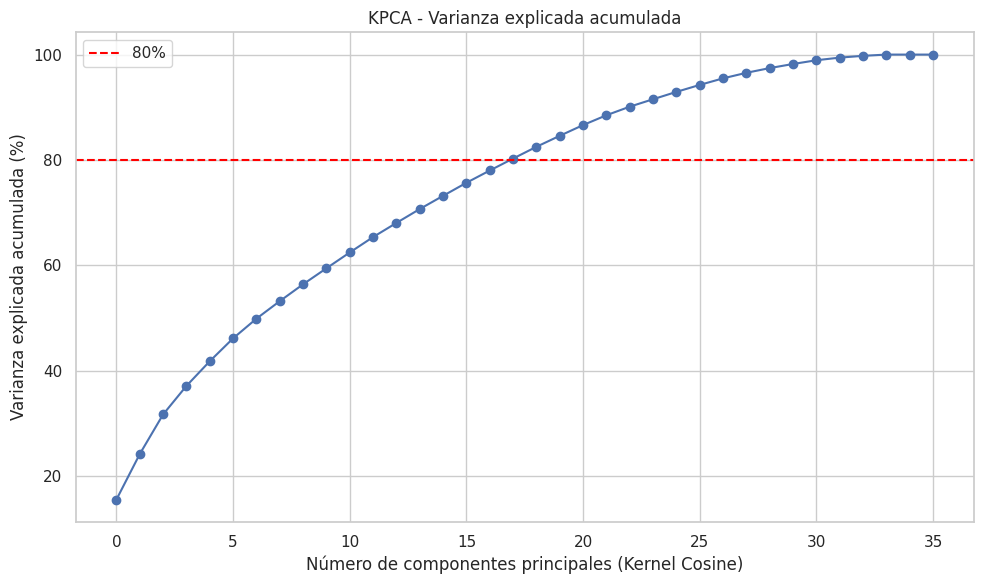


Componentes necesarias para explicar el 80% de la varianza (estimado): 18


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Liberar memoria
gc.collect()

#Cargar y preparar los datos
df = madrid_sale_train_df_expl.copy().astype(np.float32)  # Reducir precisión
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

#KernelPCA
n_components = 36
kpca = KernelPCA(
    n_components=n_components,
    kernel='cosine',
    eigen_solver='randomized',
    n_jobs=-1,
    fit_inverse_transform=False
)
X_kpca = kpca.fit_transform(df_scaled)

#Calcular varianza explicada (estimada)
component_variances = np.var(X_kpca, axis=0)
explained_variance_ratio_kpca = component_variances / np.sum(component_variances)
cumulative_variance_kpca = np.cumsum(explained_variance_ratio_kpca)

#Tabla de varianza explicada
df_varianza = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(n_components)],
    'Varianza Explicada (%)': explained_variance_ratio_kpca * 100,
    'Varianza Acumulada (%)': cumulative_variance_kpca * 100
})

print("\nVarianza explicada por cada componente principal (Kernel PCA - estimado):")
print(df_varianza.round(2))

#Gráfico
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_kpca * 100, marker='o')
plt.ylabel('Varianza explicada acumulada (%)')
plt.xlabel('Número de componentes principales (Kernel Cosine)')
plt.title('KPCA - Varianza explicada acumulada')
plt.grid(True)
plt.axhline(80, color='red', linestyle='--', label='80%')
plt.legend()
plt.tight_layout()
plt.show()

# Paso 6: Componentes necesarias para explicar el 80%
n_components_80 = np.argmax(cumulative_variance_kpca >= 0.80) + 1
print(f"\nComponentes necesarias para explicar el 80% de la varianza (estimado): {n_components_80}")



Una vez que se sabe que con 18 componentes principales es suficiente, se va a aplicar correctamente

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns
import gc
# Liberar memoria
gc.collect()

# Paso 1: Cargar y preparar los datos de entrenamiento
train_df = madrid_sale_train_df_expl.copy().astype(np.float32)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df)

# Paso 2: KernelPCA con solver aleatorizado
n_components = 18
kpca = KernelPCA(
    n_components=n_components,
    kernel='cosine',
    eigen_solver='randomized',
    n_jobs=-1,
    fit_inverse_transform=False
)
X_train_kpca = kpca.fit_transform(X_train_scaled)

Realizamos un análisis de correlación de las 2 primeras componentes principales (que son las que mas varianza explican) contra las variables originales, para ver cuales son las que tienen mas peso.

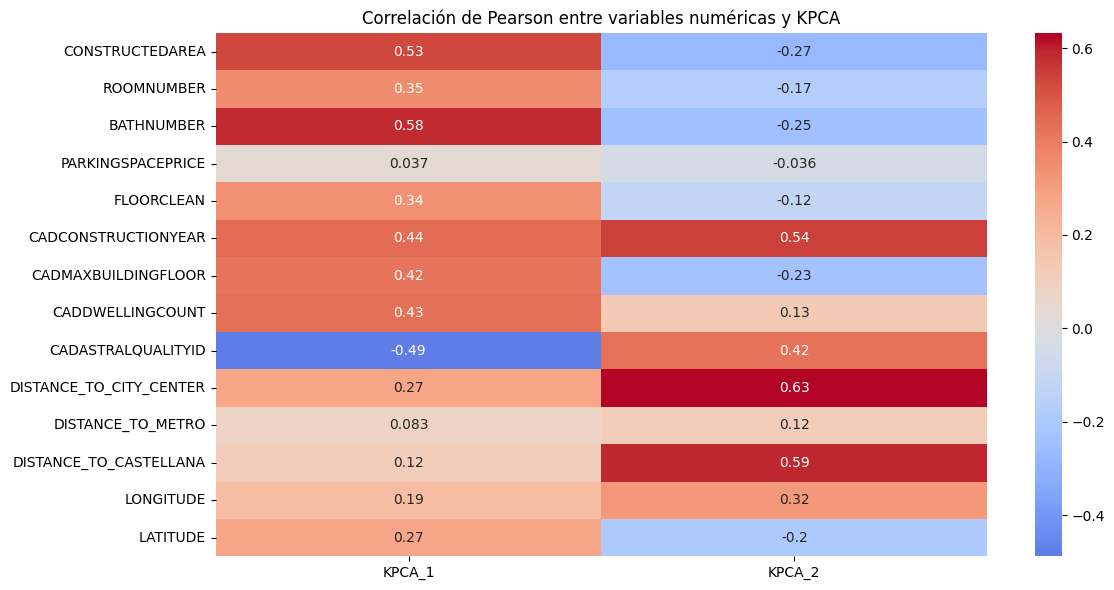

In [ ]:
from scipy.stats import pearsonr, spearmanr, f_oneway

# Paso 1: KPCA con 2 componentes ya realizado -> df_kpca
df_kpca = pd.DataFrame(X_train_kpca[:, :2], columns=['KPCA_1', 'KPCA_2'])

# Paso 2: Unimos KPCA con las variables originales
df_full = pd.concat([df_kpca.reset_index(drop=True), madrid_sale_train_df_expl.reset_index(drop=True)], axis=1)

# Inicializamos resultados
correlaciones_pearson = {}
correlaciones_spearman = {}
anova_kpca1 = {}
anova_kpca2 = {}

excluded_cols = []
for col in madrid_sale_train_df_expl.columns:
    if col in excluded_cols:
        continue

    n_unique = madrid_sale_train_df_expl[col].nunique(dropna=True)

    # Variables numéricas (continuas)
    if n_unique > 10:
        try:
            valid_rows = df_full[['KPCA_1', 'KPCA_2', col]].dropna()
            corr_pearson_1, _ = pearsonr(valid_rows['KPCA_1'], valid_rows[col])
            corr_pearson_2, _ = pearsonr(valid_rows['KPCA_2'], valid_rows[col])
            correlaciones_pearson[col] = (corr_pearson_1, corr_pearson_2)

            corr_spear_1, _ = spearmanr(valid_rows['KPCA_1'], valid_rows[col])
            corr_spear_2, _ = spearmanr(valid_rows['KPCA_2'], valid_rows[col])
            correlaciones_spearman[col] = (corr_spear_1, corr_spear_2)
        except Exception as e:
            print(f"Error en correlación con {col}: {e}")

    # Variables categóricas (pocas categorías)
    elif n_unique <= 10:
        try:
            df_clean = df_full[[col, 'KPCA_1', 'KPCA_2']].dropna()
            groups_1 = [group['KPCA_1'] for _, group in df_clean.groupby(col)]
            groups_2 = [group['KPCA_2'] for _, group in df_clean.groupby(col)]

            if len(groups_1) > 1:
                anova_kpca1[col] = f_oneway(*groups_1).pvalue
            if len(groups_2) > 1:
                anova_kpca2[col] = f_oneway(*groups_2).pvalue
        except Exception as e:
            print(f"Error en ANOVA con {col}: {e}")

# Convertimos a DataFrame para visualizar
df_corrs = pd.DataFrame.from_dict(correlaciones_pearson, orient='index', columns=['KPCA_1', 'KPCA_2'])

plt.figure(figsize=(12, 6))
sns.heatmap(df_corrs, annot=True, cmap='coolwarm', center=0)
plt.title("Correlación de Pearson entre variables numéricas y KPCA")
plt.tight_layout()
plt.show()


## PCA al conjunto de test

In [ ]:
#Cargar y preparar los datos de test
test_df = madrid_sale_test_df_expl.copy().astype(np.float32)

#Estandarización en test (usar el scaler ajustado en entrenamiento)
X_test_scaled = scaler.transform(test_df)

#Transformar el conjunto de test con KernelPCA
X_test_kpca = kpca.transform(X_test_scaled)



In [ ]:
#Cambiar nombre a la variable respuesta
y_train_kpca=madrid_sale_train_df_obj
y_test_kpca=madrid_sale_test_df_obj
#Verificar dimensiones
print(f"Dimensiones del conjunto de entrenamiento transformado: {X_train_kpca.shape}")
print(f"Dimensiones de la variable respuesta de entrenamiento: {y_train_kpca.shape}")

print(f"Dimensiones del conjunto de test transformado: {X_test_kpca.shape}")
print(f"Dimensiones de la variable respuesta de test: {y_test_kpca.shape}")

Dimensiones del conjunto de entrenamiento transformado: (75851, 18)
Dimensiones de la variable respuesta de entrenamiento: (75851,)
Dimensiones del conjunto de test transformado: (18963, 18)
Dimensiones de la variable respuesta de test: (18963,)


In [ ]:
# Si son DataFrames y quieres solo los valores:
np.save("X_train_kpca.npy", np.array(X_train_kpca))
np.save("X_test_kpca.npy", np.array(X_test_kpca))
np.save("y_train_kpca.npy", np.array(y_train_kpca))
np.save("y_test_kpca.npy", np.array(y_test_kpca))


In [ ]:
import numpy as np

# Cargar datasets
X_train_kpca = np.load('X_train_kpca.npy')
X_test_kpca = np.load('X_test_kpca.npy')
y_train_kpca = np.load('y_train_kpca.npy')
y_test_kpca = np.load('y_test_kpca.npy')


# Realización del modelo

## Regresión Lineal

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# Definir el modelo
modelo_lr = LinearRegression()

# Medir tiempo de entrenamiento
start_train = time.time()
modelo_lr.fit(X_train_kpca, y_train_kpca)
end_train = time.time()
train_time = end_train - start_train

# Medir tiempo de predicción en train
start_pred_train = time.time()
y_pred_train = modelo_lr.predict(X_train_kpca)
end_pred_train = time.time()
pred_time_train = end_pred_train - start_pred_train

# Medir tiempo de predicción en test
start_pred_test = time.time()
y_pred_test = modelo_lr.predict(X_test_kpca)
end_pred_test = time.time()
pred_time_test = end_pred_test - start_pred_test

# Función para métricas
def calcular_metricas(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    ratio_aceptable = np.mean(np.abs((y_true - y_pred) / y_true) < 0.10) * 100
    return r2, rmse, mae, mape, ratio_aceptable

# Calcular métricas
metrics_train = calcular_metricas(y_train_kpca, y_pred_train)
metrics_test = calcular_metricas(y_test_kpca, y_pred_test)

# Añadir tiempos a las métricas
metrics_train += (train_time + pred_time_train,)
metrics_test += (pred_time_test,)

# Crear tabla resumen con tiempos
df_metrics = pd.DataFrame(
    [metrics_train, metrics_test],
    index=["Entrenamiento", "Test"],
    columns=["R²", "RMSE", "MAE", "MAPE (%)", "Ratio aceptable (<10%)", "Tiempo (s)"]
)

# Mostrar resultados
print("\nMétricas de rendimiento y tiempos del modelo de regresión lineal:")
print(df_metrics.round(4))



Métricas de rendimiento y tiempos del modelo de regresión lineal:
                   R²         RMSE          MAE  MAPE (%)  \
Entrenamiento  0.5991  261252.7343  152331.9078   52.3834   
Test           0.5858  279542.1769  155666.6099   52.7797   

               Ratio aceptable (<10%)  Tiempo (s)  
Entrenamiento                 15.2549      0.0341  
Test                          15.3615      0.0009  


## Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product
import numpy as np
import pandas as pd

# Definimos los valores a explorar
param_grid = {
    'n_estimators':  [100, 200,300, 500],
    'max_depth': [None, 20, 30, 40],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Combinaciones de parámetros
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['max_features']
))

# Lista para guardar resultados
resultados = []

# Iterar sobre combinaciones
for n_est, depth, min_split, max_feat in param_combinations:
    print(f"Evaluando: n_estimators={n_est}, max_depth={depth}, min_samples_split={min_split}, max_features={max_feat}")

    modelo_rf = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=depth,
        min_samples_split=min_split,
        max_features=max_feat,
        random_state=42,
        n_jobs=-1
    )

    modelo_rf.fit(X_train_kpca, madrid_sale_train_df_obj)

    # Predicciones
    y_pred_train = modelo_rf.predict(X_train_kpca)
    y_pred_test = modelo_rf.predict(X_test_kpca)

    # Métricas para train y test
    r2_train, rmse_train, mae_train, mape_train, ratio_train = calcular_metricas(madrid_sale_train_df_obj, y_pred_train)
    r2_test, rmse_test, mae_test, mape_test, ratio_test = calcular_metricas(madrid_sale_test_df_obj, y_pred_test)

    resultados.append({
        'n_estimators': n_est,
        'max_depth': depth,
        'min_samples_split': min_split,
        'max_features': max_feat,
        'R2_Train': r2_train,
        'R2_Test': r2_test,
        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'MAE_Train': mae_train,
        'MAE_Test': mae_test,
        'MAPE_Train (%)': mape_train,
        'MAPE_Test (%)': mape_test,
        'Ratio_Train (<10%)': ratio_train,
        'Ratio_Test (<10%)': ratio_test
    })

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)

# Ordenar por R2 en Test
df_resultados_ordenado = df_resultados.sort_values(by='R2_Test', ascending=False)

# Mostrar top 5
print(df_resultados_ordenado.round(2))


Evaluando: n_estimators=100, max_depth=None, min_samples_split=2, max_features=sqrt
Evaluando: n_estimators=100, max_depth=None, min_samples_split=2, max_features=log2
Evaluando: n_estimators=100, max_depth=None, min_samples_split=5, max_features=sqrt
Evaluando: n_estimators=100, max_depth=None, min_samples_split=5, max_features=log2
Evaluando: n_estimators=100, max_depth=20, min_samples_split=2, max_features=sqrt
Evaluando: n_estimators=100, max_depth=20, min_samples_split=2, max_features=log2
Evaluando: n_estimators=100, max_depth=20, min_samples_split=5, max_features=sqrt
Evaluando: n_estimators=100, max_depth=20, min_samples_split=5, max_features=log2
Evaluando: n_estimators=100, max_depth=30, min_samples_split=2, max_features=sqrt
Evaluando: n_estimators=100, max_depth=30, min_samples_split=2, max_features=log2
Evaluando: n_estimators=100, max_depth=30, min_samples_split=5, max_features=sqrt
Evaluando: n_estimators=100, max_depth=30, min_samples_split=5, max_features=log2
Evaluand

In [ ]:
#Imprimimos resultados
df_resultados.to_excel("resultados_random_forest.xlsx", index=False)

Se va a realizar lo mismo, pero introduciendo el logaritmo de la variable objetivo

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product
import numpy as np
import pandas as pd

# Transformamos target a logarítmica
y_train_log = np.log1p(y_train_kpca)
y_test_log = np.log1p(y_test_kpca)

# Definimos los valores a explorar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Combinaciones de parámetros
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['max_features']
))

# Lista para guardar resultados
resultados_3 = []

# Iterar sobre combinaciones
for n_est, depth, min_split, max_feat in param_combinations:
    print(f"Evaluando: n_estimators={n_est}, max_depth={depth}, min_samples_split={min_split}, max_features={max_feat}")

    modelo_rf = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=depth,
        min_samples_split=min_split,
        max_features=max_feat,
        random_state=42,
        n_jobs=-1
    )

    # Entrenamiento con la variable target logarítmica
    modelo_rf.fit(X_train_kpca, y_train_log)

    # Predicciones en escala log
    y_pred_train_log = modelo_rf.predict(X_train_kpca)
    y_pred_test_log = modelo_rf.predict(X_test_kpca)

    # Volvemos a la escala original
    y_pred_train = np.expm1(y_pred_train_log)
    y_pred_test = np.expm1(y_pred_test_log)

    # Métricas usando valores reales en escala original
    r2_train, rmse_train, mae_train, mape_train, ratio_train = calcular_metricas(y_train_kpca, y_pred_train)
    r2_test, rmse_test, mae_test, mape_test, ratio_test = calcular_metricas(y_test_kpca, y_pred_test)

    resultados_3.append({
        'n_estimators': n_est,
        'max_depth': depth,
        'min_samples_split': min_split,
        'max_features': max_feat,
        'R2_Train': r2_train,
        'R2_Test': r2_test,
        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'MAE_Train': mae_train,
        'MAE_Test': mae_test,
        'MAPE_Train (%)': mape_train,
        'MAPE_Test (%)': mape_test,
        'Ratio_Train (<10%)': ratio_train,
        'Ratio_Test (<10%)': ratio_test
    })

# Convertir a DataFrame
df_resultados_3 = pd.DataFrame(resultados_3)

Evaluando: n_estimators=100, max_depth=None, min_samples_split=2, max_features=sqrt
Evaluando: n_estimators=100, max_depth=None, min_samples_split=2, max_features=log2
Evaluando: n_estimators=100, max_depth=None, min_samples_split=5, max_features=sqrt
Evaluando: n_estimators=100, max_depth=None, min_samples_split=5, max_features=log2
Evaluando: n_estimators=100, max_depth=5, min_samples_split=2, max_features=sqrt
Evaluando: n_estimators=100, max_depth=5, min_samples_split=2, max_features=log2
Evaluando: n_estimators=100, max_depth=5, min_samples_split=5, max_features=sqrt
Evaluando: n_estimators=100, max_depth=5, min_samples_split=5, max_features=log2
Evaluando: n_estimators=100, max_depth=10, min_samples_split=2, max_features=sqrt
Evaluando: n_estimators=100, max_depth=10, min_samples_split=2, max_features=log2
Evaluando: n_estimators=100, max_depth=10, min_samples_split=5, max_features=sqrt
Evaluando: n_estimators=100, max_depth=10, min_samples_split=5, max_features=log2
Evaluando: n

In [ ]:
#Imprimimos resultados
df_resultados_3.to_excel("resultados_random_forest_3.xlsx", index=False)

Modelo final

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# Aplicar logaritmo a la variable objetivo de entrenamiento
y_train_kpca_log = np.log(y_train_kpca)

# Inicializar el modelo
modelo_final_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Entrenamiento
start_train = time.time()
modelo_final_rf.fit(X_train_kpca, y_train_kpca_log)
end_train = time.time()
train_time = end_train - start_train
print(f"Tiempo de entrenamiento: {train_time:.2f} segundos")

# Predicción (en log)
start_pred = time.time()
y_pred_log = modelo_final_rf.predict(X_test_kpca)
end_pred = time.time()
pred_time = end_pred - start_pred
print(f"Tiempo de predicción: {pred_time:.4f} segundos")

Tiempo de entrenamiento: 13.14 segundos
Tiempo de predicción: 0.2018 segundos


In [ ]:
print(df_resultados)

    R2_Test      RMSE_Test      MAE_Test  MAPE_Test (%)  Ratio_Test (<10%)
0  0.843884  163084.565438  73392.893666      20.603422          43.004799


## XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product
import numpy as np
import pandas as pd

# Definir la malla de hiperparámetros a explorar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 2, 5, 10, 20, 40, 60],
    'learning_rate': [0.1, 0.2, 0.5, 1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Generar combinaciones de parámetros
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['subsample'],
    param_grid['colsample_bytree']
))

# Lista para guardar resultados
resultados_1 = []


# Iterar sobre todas las combinaciones
for n_est, depth, lr, subs, colsample in param_combinations:
    print(f"Evaluando: n_estimators={n_est}, max_depth={depth}, learning_rate={lr}, subsample={subs}, colsample_bytree={colsample}")

    modelo_xgb = XGBRegressor(
        n_estimators=n_est,
        max_depth=depth,
        learning_rate=lr,
        subsample=subs,
        colsample_bytree=colsample,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    modelo_xgb.fit(X_train_kpca, madrid_sale_train_df_obj)

    # Predicciones
    y_pred_train = modelo_xgb.predict(X_train_kpca)
    y_pred_test = modelo_xgb.predict(X_test_kpca)

    # Calcular métricas
    r2_train, rmse_train, mae_train, mape_train, ratio_train = calcular_metricas(madrid_sale_train_df_obj, y_pred_train)
    r2_test, rmse_test, mae_test, mape_test, ratio_test = calcular_metricas(madrid_sale_test_df_obj, y_pred_test)

    resultados_1.append({
        'n_estimators': n_est,
        'max_depth': depth,
        'learning_rate': lr,
        'subsample': subs,
        'colsample_bytree': colsample,
        'R2_Train': r2_train,
        'R2_Test': r2_test,

        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'MAE_Train': mae_train,
        'MAE_Test': mae_test,
        'MAPE_Train (%)': mape_train,
        'MAPE_Test (%)': mape_test,
        'Ratio_Train (<10%)': ratio_train,
        'Ratio_Test (<10%)': ratio_test
    })

# Convertir a DataFrame y ordenar
df_resultados_1_xgb = pd.DataFrame(resultados_1)
df_resultados_1_xgb_ordenado = df_resultados_1_xgb.sort_values(by='R2_Test', ascending=False)


Evaluando: n_estimators=100, max_depth=None, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.1, subsample=0.8, colsample_bytree=1
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.1, subsample=1, colsample_bytree=0.8
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.1, subsample=1, colsample_bytree=1
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.2, subsample=0.8, colsample_bytree=1
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.2, subsample=1, colsample_bytree=0.8
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.2, subsample=1, colsample_bytree=1
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.5, subsample=0.8, colsample_bytree=0.8
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.5, subsample=0.8, colsample_bytree=1
Evaluando: n_estim

In [ ]:
df_resultados_1_xgb.to_excel("resultados_XGB_1.xlsx", index=False)

Ahora se prueba con la variable objetivo logaritmica

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product
import numpy as np
import pandas as pd

# Definir la malla de hiperparámetros a explorar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 40, 60],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [1]
}

# Generar combinaciones de parámetros
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['subsample'],
    param_grid['colsample_bytree']
))

# Lista para guardar resultados
resultados_3 = []

# Aplicar transformación logarítmica a la variable objetivo
y_train_log = np.log(y_train_kpca)
y_test_log = np.log(y_test_kpca)

# Función de métricas adaptada para predicciones log-transformadas
def calcular_metricas_log(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    ratio_aceptable = np.mean(np.abs((y_true - y_pred) / y_true) < 0.10) * 100
    return r2, rmse, mae, mape, ratio_aceptable

# Iterar sobre todas las combinaciones
for n_est, depth, lr, subs, colsample in param_combinations:
    print(f"Evaluando: n_estimators={n_est}, max_depth={depth}, learning_rate={lr}, subsample={subs}, colsample_bytree={colsample}")

    modelo_xgb = XGBRegressor(
        n_estimators=n_est,
        max_depth=depth,
        learning_rate=lr,
        subsample=subs,
        colsample_bytree=colsample,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    modelo_xgb.fit(X_train_kpca, y_train_log)

    # Predicciones en escala log
    y_pred_train_log = modelo_xgb.predict(X_train_kpca)
    y_pred_test_log = modelo_xgb.predict(X_test_kpca)

    # Calcular métricas destransformando a escala original
    r2_train, rmse_train, mae_train, mape_train, ratio_train = calcular_metricas_log(y_train_log, y_pred_train_log)
    r2_test, rmse_test, mae_test, mape_test, ratio_test = calcular_metricas_log(y_test_log, y_pred_test_log)

    resultados_3.append({
        'n_estimators': n_est,
        'max_depth': depth,
        'learning_rate': lr,
        'subsample': subs,
        'colsample_bytree': colsample,
        'R2_Train': r2_train,
        'R2_Test': r2_test,
        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'MAE_Train': mae_train,
        'MAE_Test': mae_test,
        'MAPE_Train (%)': mape_train,
        'MAPE_Test (%)': mape_test,
        'Ratio_Train (<10%)': ratio_train,
        'Ratio_Test (<10%)': ratio_test
    })

# Convertir a DataFrame y ordenar
df_resultados_3_xgb = pd.DataFrame(resultados_3)

Evaluando: n_estimators=100, max_depth=20, learning_rate=0.1, subsample=0.8, colsample_bytree=1
Evaluando: n_estimators=100, max_depth=40, learning_rate=0.1, subsample=0.8, colsample_bytree=1
Evaluando: n_estimators=100, max_depth=60, learning_rate=0.1, subsample=0.8, colsample_bytree=1
Evaluando: n_estimators=200, max_depth=20, learning_rate=0.1, subsample=0.8, colsample_bytree=1
Evaluando: n_estimators=200, max_depth=40, learning_rate=0.1, subsample=0.8, colsample_bytree=1
Evaluando: n_estimators=200, max_depth=60, learning_rate=0.1, subsample=0.8, colsample_bytree=1


In [ ]:
df_resultados_3_xgb.to_excel("resultados_XGB_3.xlsx", index=False)

Evaluación del modelo

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import time

# Aplicar transformación logarítmica a la variable objetivo
y_train_log = np.log(y_train_kpca)
y_test_log = np.log(y_test_kpca)

# Función de métricas adaptada para predicciones log-transformadas
def calcular_metricas_log(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    ratio_aceptable = np.mean(np.abs((y_true - y_pred) / y_true) < 0.10) * 100
    return r2, rmse, mae, mape, ratio_aceptable

# Inicializar el modelo con los hiperparámetros indicados
modelo_xgb = XGBRegressor(
    n_estimators=200,
    max_depth=20,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Tiempo de entrenamiento
start_train = time.time()
modelo_xgb.fit(X_train_kpca, y_train_log)
end_train = time.time()
train_time = end_train - start_train

# Tiempo de predicción
start_pred = time.time()
y_pred_test_log = modelo_xgb.predict(X_test_kpca)
end_pred = time.time()
pred_time = end_pred - start_pred

# Mostrar resultados
print(f"Tiempo de entrenamiento: {train_time:.2f} segundos")
print(f"Tiempo de predicción: {pred_time:.4f} segundos")


Tiempo de entrenamiento: 54.07 segundos
Tiempo de predicción: 0.1288 segundos


## Red Neuronal Densa

Básica

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import time

# Escalar los datos (muy importante para redes neuronales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_kpca)
X_test_scaled = scaler.transform(X_test_kpca)

# Crear modelo
modelo_dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),

    Dense(1)  # Salida de regresión
])

# Compilar el modelo
modelo_dnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

# Early stopping para val_mae con paciencia de 4 épocas
early_stop = EarlyStopping(monitor='val_mae', patience=4, restore_best_weights=True)

# Entrenar
start_train = time.time()
historial = modelo_dnn.fit(
    X_train_scaled,
    madrid_sale_train_df_obj,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
end_train = time.time()

# Tiempo de entrenamiento
tiempo_entrenamiento = end_train - start_train

# Predicción
start_pred = time.time()
y_pred_dnn = modelo_dnn.predict(X_test_scaled).flatten()
end_pred = time.time()

tiempo_prediccion = end_pred - start_pred


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 225393639424.0000 - mae: 302269.6875 - val_loss: 60997844992.0000 - val_mae: 142458.3594
Epoch 2/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 69793669120.0000 - mae: 151783.6094 - val_loss: 50702852096.0000 - val_mae: 126718.0938
Epoch 3/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 59345203200.0000 - mae: 134866.5625 - val_loss: 41752465408.0000 - val_mae: 107663.5078
Epoch 4/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 54428979200.0000 - mae: 125790.8438 - val_loss: 39519719424.0000 - val_mae: 103153.5078
Epoch 5/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 49791504384.0000 - mae: 122219.8281 - val_loss: 40261652480.0000 - val_mae: 103166.5703
Epoch 6/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 53094248448.0000 - mae: 122615.5078 - val_loss: 38627364864.0000 - val_mae: 101303.3750
Epoch 7/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 51595714560.0000 - mae: 12209

In [ ]:
# Evaluar
r2, rmse, mae, mape, ratio = calcular_metricas(madrid_sale_test_df_obj, y_pred_dnn)

# Mostrar resultados
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Ratio aceptable (<10%): {ratio:.2f}%")
print(f"Tiempo entrenamiento: {tiempo_entrenamiento:.2f}s")
print(f"Tiempo predicción: {tiempo_prediccion:.2f}s")


R²: 0.765
RMSE: 210,608.87
MAE: 100,072.90
MAPE: 25.63%
Ratio aceptable (<10%): 26.45%
Tiempo entrenamiento: 91.10s
Tiempo predicción: 1.79s


## Modelo transformer

In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Modelo Transformer
class EnhancedTransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.2):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, activation='gelu', batch_first=True, norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.regressor = nn.Sequential(
            nn.LayerNorm(d_model * input_dim),
            nn.Linear(d_model * input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.flatten(start_dim=1)
        return self.regressor(x)

# Escalado
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_kpca.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_kpca.reshape(-1, 1))

# DataLoader
train_dataset = TensorDataset(
    torch.tensor(X_train_kpca, dtype=torch.float32),
    torch.tensor(y_train_scaled, dtype=torch.float32)
)
test_dataset = TensorDataset(
    torch.tensor(X_test_kpca, dtype=torch.float32),
    torch.tensor(y_test_scaled, dtype=torch.float32)
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Entrenamiento con EarlyStopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedTransformerRegressor(input_dim=X_train_kpca.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Early stopping manual
patience = 4
best_mae = float('inf')
epochs_no_improve = 0
best_model_state = None
num_epochs = 100

def get_preds(loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            preds.append(pred)
            trues.append(yb.numpy())
    return np.vstack(preds).flatten(), np.vstack(trues).flatten()

start_train = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)

    # Evaluar en test para MAE
    val_preds_scaled, val_true_scaled = get_preds(test_loader)
    val_mae = mean_absolute_error(val_true_scaled, val_preds_scaled)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val MAE: {val_mae:.4f}")

    if val_mae < best_mae:
        best_mae = val_mae
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n Early stopping: no mejora en {patience} épocas consecutivas.")
            break

# Restaurar mejores pesos
if best_model_state:
    model.load_state_dict(best_model_state)

end_train = time.time()
print(f"\n⏱️ Tiempo total de entrenamiento: {end_train - start_train:.2f} segundos")

# Predicción y desescalado
# Tiempo de predicción en test
train_preds_scaled, train_true_scaled = get_preds(train_loader)
start_test = time.time()
test_preds_scaled, test_true_scaled = get_preds(test_loader)
end_test = time.time()
print(f"\n⏱️ Tiempo de predicción en test: {end_test - start_test:.4f} segundos")



train_preds = scaler_y.inverse_transform(train_preds_scaled.reshape(-1, 1)).flatten()
train_true = scaler_y.inverse_transform(train_true_scaled.reshape(-1, 1)).flatten()
test_preds = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()
test_true = scaler_y.inverse_transform(test_true_scaled.reshape(-1, 1)).flatten()

print("\nPrimeros 5 valores predichos vs reales (test):")
for pred, real in zip(test_preds[:5], test_true[:5]):
    print(f"Predicho: {pred:.2f}, Real: {real:.2f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/100 | Train Loss: 0.3240 | Val MAE: 0.2563
Epoch 2/100 | Train Loss: 0.2507 | Val MAE: 0.2415
Epoch 3/100 | Train Loss: 0.2388 | Val MAE: 0.2393
Epoch 4/100 | Train Loss: 0.2269 | Val MAE: 0.2490
Epoch 5/100 | Train Loss: 0.2216 | Val MAE: 0.2427
Epoch 6/100 | Train Loss: 0.2160 | Val MAE: 0.2358
Epoch 7/100 | Train Loss: 0.2122 | Val MAE: 0.2340
Epoch 8/100 | Train Loss: 0.2099 | Val MAE: 0.2716
Epoch 9/100 | Train Loss: 0.2069 | Val MAE: 0.2446
Epoch 10/100 | Train Loss: 0.2115 | Val MAE: 0.2387
Epoch 11/100 | Train Loss: 0.2045 | Val MAE: 0.2508

🛑 Early stopping: no mejora en 4 épocas consecutivas.

⏱️ Tiempo total de entrenamiento: 165.41 segundos

⏱️ Tiempo de predicción en test: 0.7423 segundos

Primeros 5 valores predichos vs reales (test):
Predicho: 50570.43, Real: 104999.99
Predicho: 470733.25, Real: 399000.00
Predicho: 1788232.62, Real: 777000.00
Predicho: 87754.99, Real: 135000.00
Predicho: 233244.33, Real: 319000.00


In [ ]:
# Métricas
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def ratio_under_10(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true < 0.10) * 100

print("\nTrain metrics:")
print(f"R2: {r2_score(train_true, train_preds):.4f}")
print(f"RMSE: {mean_squared_error(train_true, train_preds):.2f}")
print(f"MAE: {mean_absolute_error(train_true, train_preds):.2f}")
print(f"MAPE (%): {mape(train_true, train_preds):.2f}")
print(f"Ratio (<10% error) (%): {ratio_under_10(train_true, train_preds):.2f}")

print("\nTest metrics:")
print(f"R2: {r2_score(test_true, test_preds):.4f}")
print(f"RMSE: {mean_squared_error(test_true, test_preds):.2f}")
print(f"MAE: {mean_absolute_error(test_true, test_preds):.2f}")
print(f"MAPE (%): {mape(test_true, test_preds):.2f}")
print(f"Ratio (<10% error) (%): {ratio_under_10(test_true, test_preds):.2f}")

print("\nPrimeros 5 valores predichos vs reales (test):")
for pred, real in zip(test_preds[:5], test_true[:5]):
    print(f"Predicho: {pred:.2f}, Real: {real:.2f}")



Train metrics:
R2: 0.7914
RMSE: 35524050944.00
MAE: 100047.45
MAPE (%): 25.65
Ratio (<10% error) (%): 26.30

Test metrics:
R2: 0.7904
RMSE: 39552692224.00
MAE: 103475.55
MAPE (%): 26.02
Ratio (<10% error) (%): 25.62

Primeros 5 valores predichos vs reales (test):
Predicho: 50570.43, Real: 104999.99
Predicho: 470733.25, Real: 399000.00
Predicho: 1788232.62, Real: 777000.00
Predicho: 87754.99, Real: 135000.00
Predicho: 233244.33, Real: 319000.00
